Name: Tian Liu  
UIN: 525004380

In [1]:
!nvidia-smi

Mon May  2 18:13:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    40W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/MyDrive/Colab Notebooks/CSCE636_DeepLearning/Project3_LanguageModeling/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/CSCE636_DeepLearning/Project3_LanguageModeling


### Load Train Data

In [3]:
import pickle
import numpy as np

train_input = pickle.load(open('DS_5_train_input_prefixList', 'rb'))
train_output = pickle.load(open('DS_5_train_input_nextWord', 'rb'))

In [36]:
train_input_p2 = pickle.load(open('../Project2_MachineTranslation/DS_5_train_input', 'rb'))
for i in range(3):
  print(train_input_p2[i])
  print()

a g b f a f a e a k a j c f b f c d a k a k c e b g a h a k b d b f b f b d c d 

a k a e a e a e a i a f b e a i c d b g c g c e a i c f a e c f c d c d 

a k c f a d a g b e a h c d a h a k a k b f b e b e b d c d a e c d b f 



In [5]:
# examine the train data

for i in range(3):
  print(train_input[i])
  print('->')
  print(train_output[i])
  print()

['a', 'g', 'b', 'f', 'a', 'f', 'a', 'e', 'a', 'k', 'a', 'j', 'c', 'f', 'b', 'f', 'c', 'd', 'a', 'k']
->
a

['a', 'k', 'a', 'e', 'a', 'e', 'a', 'e', 'a', 'i', 'a', 'f', 'b', 'e', 'a', 'i', 'c', 'd', 'b', 'g']
->
c

['a', 'k', 'c', 'f', 'a', 'd', 'a', 'g', 'b', 'e', 'a', 'h', 'c', 'd', 'a', 'h', 'a', 'k', 'a']
->
k



In [6]:
# check the data and vocab size in given training data
max_len = 0
max_ct = 0
for text in train_input:
  max_ct = max(max_ct, len(text))
  for word in text:
    max_len = max(max_len, len(word))

print('max_len', max_len)
print('max_ct', max_ct)

max_len = 0
max_ct = 0
for text in train_output:
  max_ct = max(max_ct, len(text))
  for word in text:
    max_len = max(max_len, len(word))

print('max_len', max_len)
print('max_ct', max_ct)

max_len 1
max_ct 48
max_len 1
max_ct 1


In [7]:
# prepare train_texts by concatenate prefix and nextWord

train_texts = []
for i in range(len(train_input)):
# for i in range(10):
  prefix = train_input[i]
  nextword = train_output[i]
  sen = ' '.join(train_input[i]) + ' ' + train_output[i]
  train_texts.append(sen)

  # print('prefix', prefix)
  # print('nextword', nextword)
  # print('sen',sen)
  # print("-----")

In [37]:
# use project 2 train text data
train_texts_p2 = train_input_p2

### Prepare TextVectorization Layer

In [48]:
from tensorflow.keras.layers import TextVectorization

sequence_length = 65 # max len in train input of project is 64
vocab_size = 13
# since only 26 letters
text_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
# text_vectorization.adapt(train_texts)
text_vectorization.adapt(train_texts_p2)
print(len(text_vectorization.get_vocabulary()))

13


In [49]:
# split into train and val

import random

random.shuffle(train_texts)
num_val_samples = int(0.15 * len(train_texts))
num_train_samples = len(train_texts) - num_val_samples

train_set = train_texts[:num_train_samples]
val_set = train_texts[num_train_samples:]

print(len(train_set))
print(len(val_set))

4250
750


In [50]:
# prepare the input and output for the lm dataset

# train_vec = text_vectorization(train_set)
train_vec = text_vectorization(train_texts_p2) # train on project2 train data which has longer sentences

X_train = train_vec[:, :-1]
y_train = train_vec[:, 1:]

val_vec = text_vectorization(val_set)
X_val = val_vec[:, :-1]
y_val = val_vec[:, 1:]

print(train_vec[10])
print(X_train[10])
print(y_train[10])

tf.Tensor(
[ 2 11  3  6  2  9  2  5  3  7  2  8  2  8  4  7  2 10  2  9  4  5  4  7
  4  8  4  8  2  6  4  8  4  7  2  9  4  8  2  7  3  7  2  9  3  6  2  5
  3  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0], shape=(65,), dtype=int64)
tf.Tensor(
[ 2 11  3  6  2  9  2  5  3  7  2  8  2  8  4  7  2 10  2  9  4  5  4  7
  4  8  4  8  2  6  4  8  4  7  2  9  4  8  2  7  3  7  2  9  3  6  2  5
  3  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0], shape=(64,), dtype=int64)
tf.Tensor(
[11  3  6  2  9  2  5  3  7  2  8  2  8  4  7  2 10  2  9  4  5  4  7  4
  8  4  8  2  6  4  8  4  7  2  9  4  8  2  7  3  7  2  9  3  6  2  5  3
  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0], shape=(64,), dtype=int64)


### Transformer based seq-to-seq model

In [51]:
import tensorflow as tf
from tensorflow.keras import layers

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
          num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
          num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super(TransformerDecoder, self).get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

#### Transformer-based language model

In [57]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
embed_dim = 128
latent_dim = 512
num_heads = 8

inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(vocab_size, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [58]:
tokens_index = dict(enumerate(text_vectorization.get_vocabulary()))

class predNextAcc(keras.callbacks.Callback):
    def __init__(self,
                 prefix,
                 nextWord,
                #  model_input_length,
                #  temperatures=(1.,),
                #  print_freq=1
                 ):
        self.prefix = text_vectorization(prefix)
        self.nextWord = nextWord
        # self.model_input_length = model_input_length
        # self.temperatures = temperatures
        # self.print_freq = print_freq
        

    def on_epoch_end(self, epoch, logs=None):
        tokenized_sentences = self.prefix
        predictions = self.model(tokenized_sentences)
        pred_next = predictions[:, 0, :]
        print('\npred_next.shape', pred_next.shape)
        next_tokens = np.argmax(pred_next, axis=1) # check axis=1 here
        print('next_tokens.shape', next_tokens.shape)

        pred_nextWords = [tokens_index[i] for i in next_tokens]

        # target_tokens = text_vectorization(self.nextWord)
        # print('target_tokens.shape', target_tokens.shape)

        target_words = self.nextWord
        wordAcc = 0
        match_ct = 0
        total_ct = len(target_words)
        for i in range(total_ct):
          if pred_nextWords[i] == target_words[i]:
            match_ct += 1
        print('match_ct =', match_ct)
        print('total_ct =', total_ct)
        print('wordAcc =', match_ct / total_ct)

        # for temperature in self.temperatures:
        #     print("== Generating with temperature", temperature)
        #     sentence = self.prompt
        #     for i in range(self.generate_length):
        #         tokenized_sentence = text_vectorization([sentence])
        #         predictions = self.model(tokenized_sentence)
        #         next_token = sample_next(predictions[0, i, :])
        #         sampled_token = tokens_index[next_token]
        #         sentence += " " + sampled_token
        #     print(sentence)

prefix = [sen.strip()[:-2] for sen in train_set[:300]]
nextWord = [sen.strip()[-1] for sen in train_set[:300]]

# prefix = [sen.strip()[:-2] for sen in train_texts[:1000]]
# nextWord = [sen.strip()[-1] for sen in train_texts[:1000]]

# prefix = [sen.strip()[:-2] for sen in val_set]
# nextWord = [sen.strip()[-1] for sen in val_set]

print(prefix)
print(nextWord)
# stop

predNextAcc_callback = predNextAcc(prefix, nextWord)

history = model.fit(X_train, y_train, batch_size=64, shuffle=True, validation_data=(X_val, y_val), epochs=20, callbacks=[predNextAcc_callback])
# history = model.fit(X_train, y_train, batch_size=64, shuffle=True, validation_data=(X_val, y_val), epochs=20)

['a f a d b e a g a k a g b d c g b g c f a h a e a', 'a h b d a f a d a i a e b g a g b f a k a d b e', 'a f a k a d b g b d a e a h c f a k c e b f a i b g b d', 'a d a g a h b e c f a k c f c e b f a j c d a d', 'a d a i a j b f c g b d c g a h b g b e a f c d a g', 'a d a h b f a f b e a j c g a g a h c g', 'a d c d a k b g a e a g a j a g c d a f a e', 'a j a e a e a k c e c g a i c d b e a j a d c', 'a i a k b f b e b f a g a g c d a i a d b g c d a k c e c g a', 'a j a i c g b f c d b g a f c d a i a d a h b g a e c', 'a g b d a d c f a i a k a f a e a i b g a d', 'a j a j a g a e c e c d a d a k c d a d b d c d a d b', 'a f c e a f a h a e a f a e a f a f a g c f b g b g c e b e', 'a h c g a e a f a e b g a d a e c e', 'a i a i c f a g b e a k a i a k a f b e a i b d b e a f a k b d', 'a e a f c g a f c g a e a e a g c', 'a i a k a f b g a d c f a d c e a h b g', 'a k b e a i a e a e a k b f a g a f b d', 'a h c f b d a d a k a e c g a k a e a e c d a h a e c e a e c e a', 'a d

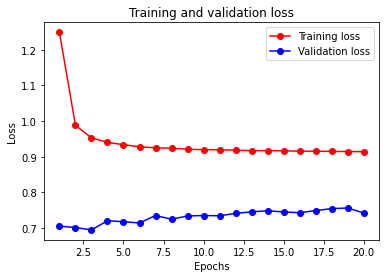

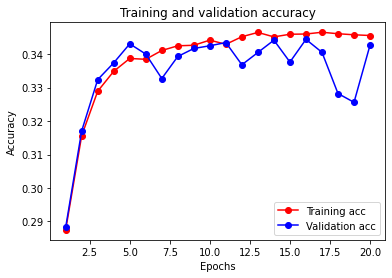

In [59]:
# plot training and validation loss and acc

import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "r", marker="o", label="Training loss")
plt.plot(epochs, val_loss_values, "b", marker="o",label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "r", marker="o", label="Training acc")
plt.plot(epochs, val_acc, "b", marker="o", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()